# 24. Option Pricing Foundations

**Goal:** Derive the Black-Scholes formula from risk-neutral pricing, verify it with Monte Carlo simulation,
compute Greeks via finite differences, validate put-call parity, and extract implied volatility from market prices.

The central result of continuous-time mathematical finance is that in a complete, arbitrage-free market,
the price of a European derivative with payoff $h(S_T)$ is:

$$V_0 = \mathbb{E}^{\mathbb{Q}}\!\left[e^{-rT}\, h(S_T)\right]$$

where the expectation is taken under the **risk-neutral measure** $\mathbb{Q}$, under which the stock
follows geometric Brownian motion with drift $r$ (the risk-free rate) rather than $\mu$:

$$S_T = S_0 \exp\!\left[\left(r - \tfrac{1}{2}\sigma^2\right)T + \sigma W_T^{\mathbb{Q}}\right]$$

This notebook builds the full option pricing toolkit from this foundation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import brentq

np.random.seed(42)

## 1. Black-Scholes Formula Derivation Recap

For a European call with strike $K$ and maturity $T$, the risk-neutral pricing formula gives:

$$C_0 = \mathbb{E}^{\mathbb{Q}}\!\left[e^{-rT}(S_T - K)^+\right]$$

Under $\mathbb{Q}$, $\ln S_T \sim \mathcal{N}\!\left(\ln S_0 + (r - \tfrac{1}{2}\sigma^2)T,\; \sigma^2 T\right)$.
Writing $S_T = S_0 e^{(r - \sigma^2/2)T + \sigma\sqrt{T}\,Z}$ where $Z \sim \mathcal{N}(0,1)$, the expectation evaluates to:

$$C_0 = S_0\,\Phi(d_1) - K e^{-rT}\,\Phi(d_2)$$

where

$$d_1 = \frac{\ln(S_0/K) + (r + \tfrac{1}{2}\sigma^2)T}{\sigma\sqrt{T}}, \qquad d_2 = d_1 - \sigma\sqrt{T}$$

**Sketch of derivation:**
1. The payoff $(S_T - K)^+$ is positive when $S_T > K$, i.e., when $Z > -d_2$.
2. The integral $\int_{-d_2}^{\infty} S_0 e^{(r-\sigma^2/2)T + \sigma\sqrt{T}z}\,\phi(z)\,dz$
   simplifies via completing the square to $S_0 e^{rT}\,\Phi(d_1)$.
3. The $-K$ part contributes $-K\,\Phi(d_2)$, and the $e^{-rT}$ discount gives the formula.

For a European put: $P_0 = K e^{-rT}\,\Phi(-d_2) - S_0\,\Phi(-d_1)$.

Parameters: S0=100.0, K=100.0, T=1.0, r=0.05, sigma=0.2
BS Call price: 10.450584
BS Put price:  5.573526

Numerical integration check: 10.450584
Difference from BS formula:  1.25e-08


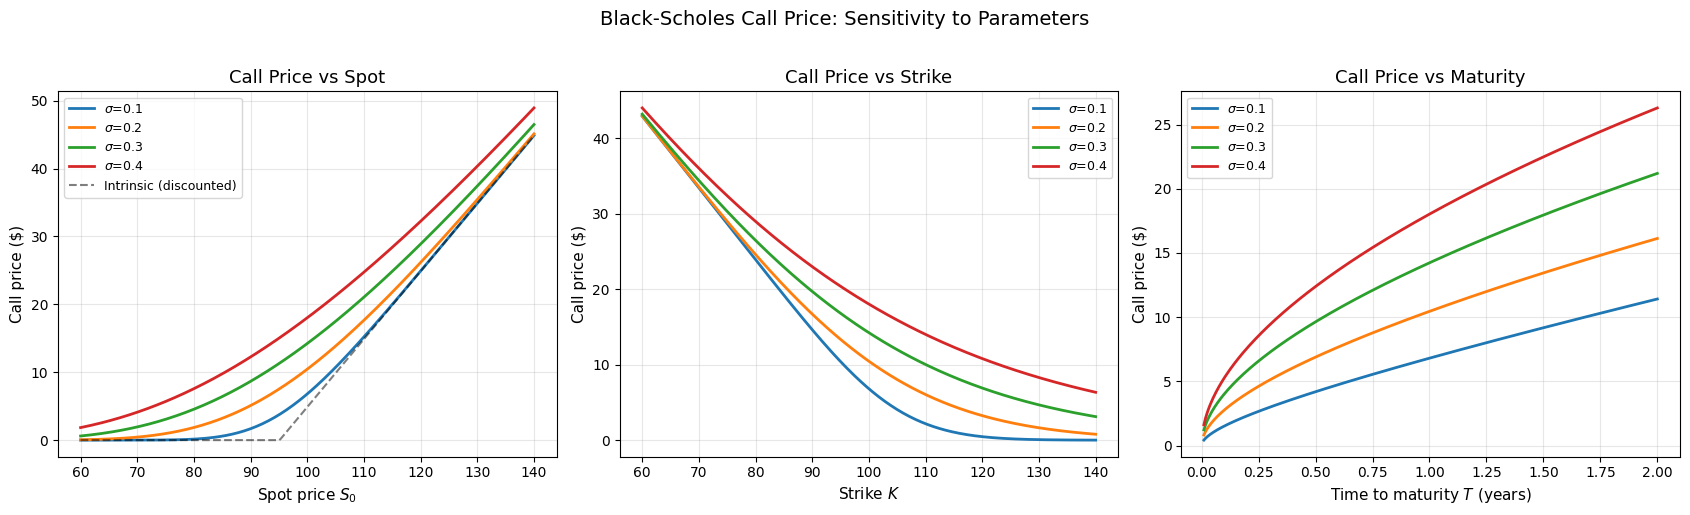

In [2]:
def bs_call(S, K, T, r, sigma):
    """Black-Scholes European call price."""
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * stats.norm.cdf(d1) - K * np.exp(-r * T) * stats.norm.cdf(d2)


def bs_put(S, K, T, r, sigma):
    """Black-Scholes European put price."""
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-r * T) * stats.norm.cdf(-d2) - S * stats.norm.cdf(-d1)


# Parameters
S0, K, T, r, sigma = 100.0, 100.0, 1.0, 0.05, 0.20

call_price = bs_call(S0, K, T, r, sigma)
put_price = bs_put(S0, K, T, r, sigma)

print(f"Parameters: S0={S0}, K={K}, T={T}, r={r}, sigma={sigma}")
print(f"BS Call price: {call_price:.6f}")
print(f"BS Put price:  {put_price:.6f}")

# Verify by numerical integration of E^Q[e^{-rT}(S_T - K)^+]
z = np.linspace(-10, 10, 100000)
dz = z[1] - z[0]
S_T = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * z)
payoff = np.maximum(S_T - K, 0)
call_numerical = np.exp(-r * T) * np.sum(payoff * stats.norm.pdf(z) * dz)
print(f"\nNumerical integration check: {call_numerical:.6f}")
print(f"Difference from BS formula:  {abs(call_numerical - call_price):.2e}")

# --- Visualization: BS price surface ---
fig, axes = plt.subplots(1, 3, figsize=(17, 5))

# Panel 1: Call price vs spot for different volatilities
ax = axes[0]
S_range = np.linspace(60, 140, 300)
for sig in [0.10, 0.20, 0.30, 0.40]:
    prices = bs_call(S_range, K, T, r, sig)
    ax.plot(S_range, prices, linewidth=2, label=f'$\\sigma$={sig}')
ax.plot(S_range, np.maximum(S_range - K * np.exp(-r * T), 0), 'k--',
        linewidth=1.5, alpha=0.5, label='Intrinsic (discounted)')
ax.set_xlabel('Spot price $S_0$', fontsize=11)
ax.set_ylabel('Call price ($)', fontsize=11)
ax.set_title('Call Price vs Spot', fontsize=13)
ax.legend(fontsize=9); ax.grid(True, alpha=0.3)

# Panel 2: Call price vs strike
ax = axes[1]
K_range = np.linspace(60, 140, 300)
for sig in [0.10, 0.20, 0.30, 0.40]:
    prices = bs_call(S0, K_range, T, r, sig)
    ax.plot(K_range, prices, linewidth=2, label=f'$\\sigma$={sig}')
ax.set_xlabel('Strike $K$', fontsize=11)
ax.set_ylabel('Call price ($)', fontsize=11)
ax.set_title('Call Price vs Strike', fontsize=13)
ax.legend(fontsize=9); ax.grid(True, alpha=0.3)

# Panel 3: Call price vs time to maturity
ax = axes[2]
T_range = np.linspace(0.01, 2.0, 300)
for sig in [0.10, 0.20, 0.30, 0.40]:
    prices = bs_call(S0, K, T_range, r, sig)
    ax.plot(T_range, prices, linewidth=2, label=f'$\\sigma$={sig}')
ax.set_xlabel('Time to maturity $T$ (years)', fontsize=11)
ax.set_ylabel('Call price ($)', fontsize=11)
ax.set_title('Call Price vs Maturity', fontsize=13)
ax.legend(fontsize=9); ax.grid(True, alpha=0.3)

plt.suptitle('Black-Scholes Call Price: Sensitivity to Parameters', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 2. Monte Carlo Pricing Under $\mathbb{Q}$

We simulate $M$ independent paths of geometric Brownian motion under the risk-neutral measure:

$$S_T^{(i)} = S_0 \exp\!\left[\left(r - \tfrac{1}{2}\sigma^2\right)T + \sigma\sqrt{T}\,Z_i\right], \quad Z_i \sim \mathcal{N}(0,1)$$

The Monte Carlo estimate of the call price is:

$$\hat{C}_M = e^{-rT} \cdot \frac{1}{M}\sum_{i=1}^{M}(S_T^{(i)} - K)^+$$

By the **strong law of large numbers**, $\hat{C}_M \to C_0$ almost surely as $M \to \infty$.
The CLT gives a 95% confidence interval:

$$\hat{C}_M \pm 1.96 \cdot \frac{\hat{\sigma}_{\text{payoff}}}{\sqrt{M}}$$

where $\hat{\sigma}_{\text{payoff}}$ is the sample standard deviation of the discounted payoffs.

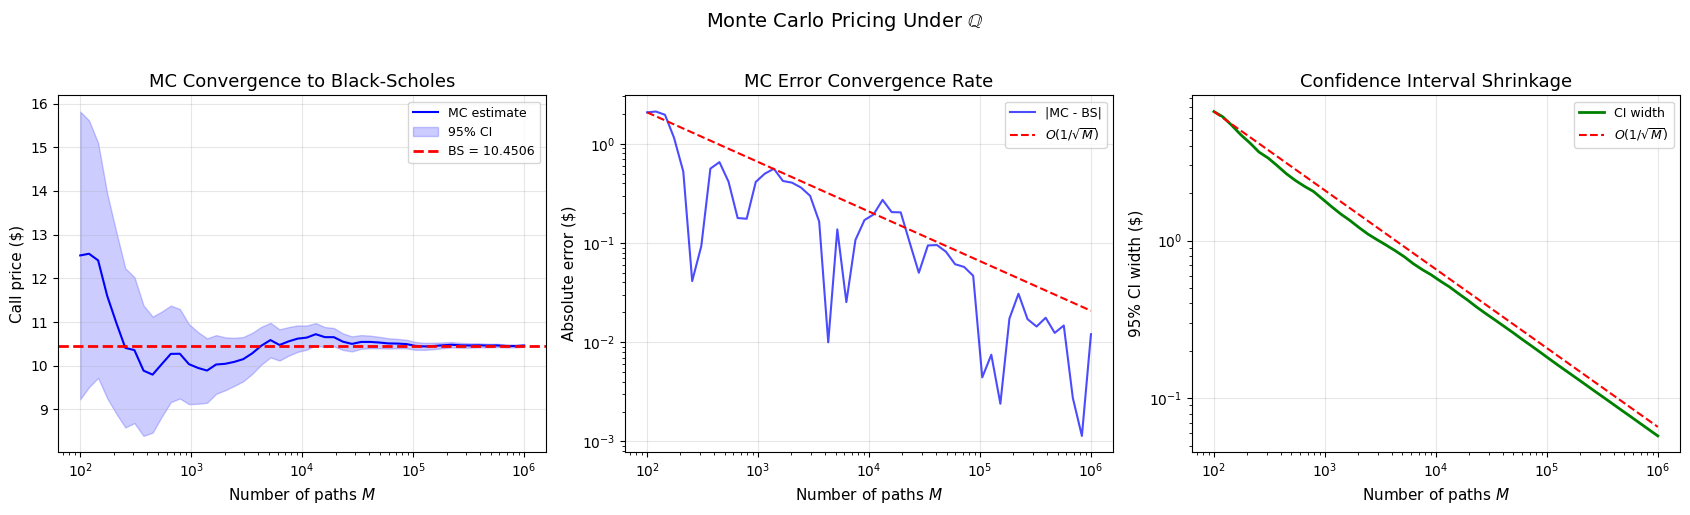

BS analytical price:  10.450584
MC with 1,000,000 paths: 10.462618
95% CI: [10.433753, 10.491483]
CI width: 0.057730


In [3]:
S0, K, T, r, sigma = 100.0, 100.0, 1.0, 0.05, 0.20
bs_true = bs_call(S0, K, T, r, sigma)

# --- Convergence study ---
M_values = np.logspace(2, 6, 50).astype(int)
mc_prices = []
mc_ci_low = []
mc_ci_high = []

np.random.seed(123)
# Generate a large pool of random numbers and use subsets
Z_all = np.random.randn(M_values[-1])

for M in M_values:
    Z = Z_all[:M]
    S_T = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
    disc_payoffs = np.exp(-r * T) * np.maximum(S_T - K, 0)
    price = np.mean(disc_payoffs)
    se = np.std(disc_payoffs, ddof=1) / np.sqrt(M)
    mc_prices.append(price)
    mc_ci_low.append(price - 1.96 * se)
    mc_ci_high.append(price + 1.96 * se)

mc_prices = np.array(mc_prices)
mc_ci_low = np.array(mc_ci_low)
mc_ci_high = np.array(mc_ci_high)

# --- Visualization ---
fig, axes = plt.subplots(1, 3, figsize=(17, 5))

# Panel 1: MC convergence to BS
ax = axes[0]
ax.semilogx(M_values, mc_prices, 'b-', linewidth=1.5, label='MC estimate')
ax.fill_between(M_values, mc_ci_low, mc_ci_high, alpha=0.2, color='blue', label='95% CI')
ax.axhline(bs_true, color='red', linestyle='--', linewidth=2, label=f'BS = {bs_true:.4f}')
ax.set_xlabel('Number of paths $M$', fontsize=11)
ax.set_ylabel('Call price ($)', fontsize=11)
ax.set_title('MC Convergence to Black-Scholes', fontsize=13)
ax.legend(fontsize=9); ax.grid(True, alpha=0.3)

# Panel 2: Absolute error
ax = axes[1]
ax.loglog(M_values, np.abs(mc_prices - bs_true), 'b-', linewidth=1.5, alpha=0.7, label='|MC - BS|')
# Reference: 1/sqrt(M) decay
ref_scale = np.abs(mc_prices[0] - bs_true) * np.sqrt(M_values[0])
ax.loglog(M_values, ref_scale / np.sqrt(M_values), 'r--', linewidth=1.5, label='$O(1/\\sqrt{M})$')
ax.set_xlabel('Number of paths $M$', fontsize=11)
ax.set_ylabel('Absolute error ($)', fontsize=11)
ax.set_title('MC Error Convergence Rate', fontsize=13)
ax.legend(fontsize=9); ax.grid(True, alpha=0.3)

# Panel 3: CI width
ax = axes[2]
ci_width = mc_ci_high - mc_ci_low
ax.loglog(M_values, ci_width, 'g-', linewidth=2, label='CI width')
ax.loglog(M_values, ci_width[0] * np.sqrt(M_values[0]) / np.sqrt(M_values),
          'r--', linewidth=1.5, label='$O(1/\\sqrt{M})$')
ax.set_xlabel('Number of paths $M$', fontsize=11)
ax.set_ylabel('95% CI width ($)', fontsize=11)
ax.set_title('Confidence Interval Shrinkage', fontsize=13)
ax.legend(fontsize=9); ax.grid(True, alpha=0.3)

plt.suptitle('Monte Carlo Pricing Under $\\mathbb{Q}$', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Final estimate with 1M paths
print(f"BS analytical price:  {bs_true:.6f}")
print(f"MC with {M_values[-1]:,} paths: {mc_prices[-1]:.6f}")
print(f"95% CI: [{mc_ci_low[-1]:.6f}, {mc_ci_high[-1]:.6f}]")
print(f"CI width: {ci_width[-1]:.6f}")

## 3. Greeks via Finite Differences

The **Greeks** measure the sensitivity of option prices to changes in underlying parameters.
They are essential for hedging and risk management.

| Greek | Definition | Finite Difference Approximation |
|-------|-----------|--------------------------------|
| **Delta** ($\Delta$) | $\frac{\partial C}{\partial S}$ | $\frac{C(S+h) - C(S-h)}{2h}$ |
| **Gamma** ($\Gamma$) | $\frac{\partial^2 C}{\partial S^2}$ | $\frac{C(S+h) - 2C(S) + C(S-h)}{h^2}$ |
| **Vega** ($\mathcal{V}$) | $\frac{\partial C}{\partial \sigma}$ | $\frac{C(\sigma+h) - C(\sigma-h)}{2h}$ |
| **Theta** ($\Theta$) | $\frac{\partial C}{\partial T}$ | $\frac{C(T-h) - C(T)}{h}$ |

The analytical Greeks from the Black-Scholes formula are:

$$\Delta = \Phi(d_1), \quad \Gamma = \frac{\phi(d_1)}{S_0 \sigma\sqrt{T}}, \quad \mathcal{V} = S_0 \phi(d_1)\sqrt{T}$$

$$\Theta = -\frac{S_0 \phi(d_1) \sigma}{2\sqrt{T}} - rKe^{-rT}\Phi(d_2)$$

We also compute Greeks by **bumping Monte Carlo simulations** --- re-running the MC pricer
with shifted parameters and the same random draws.

Greek      Analytical  Finite Diff    MC Bumped
------------------------------------------------
Delta        0.636831     0.636831     0.636031
Gamma        0.018762     0.018762     0.018770
Vega        37.524035    37.524004    37.492892
Theta       -6.414028    -6.416906    -6.410407


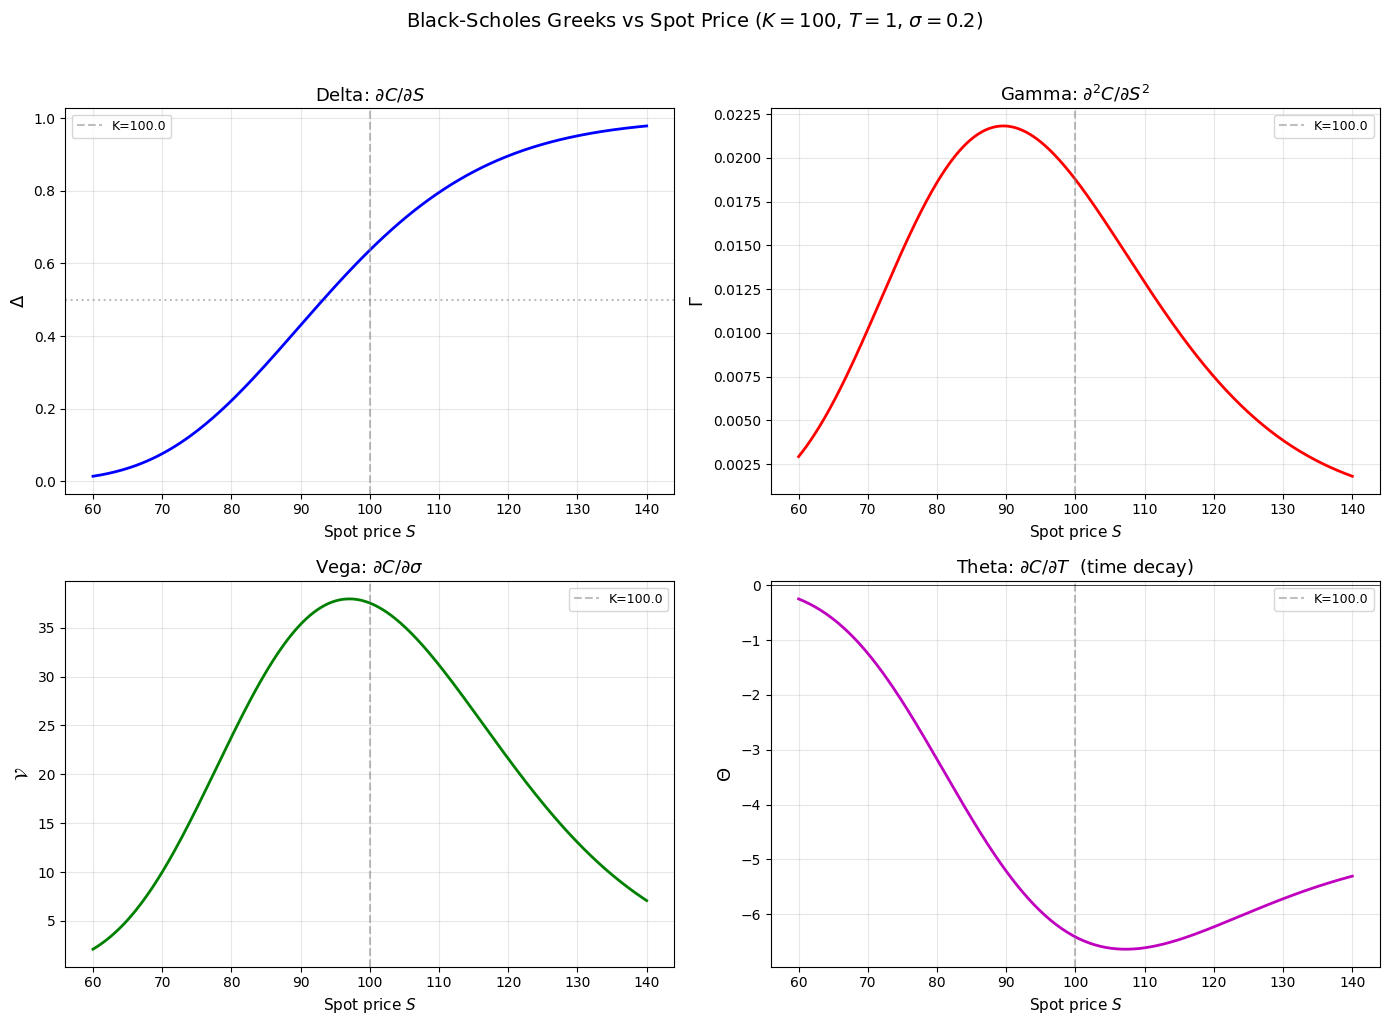

In [4]:
S0, K, T, r, sigma = 100.0, 100.0, 1.0, 0.05, 0.20

# --- Analytical Greeks ---
def bs_greeks_analytical(S, K, T, r, sigma):
    """Compute all Black-Scholes Greeks analytically."""
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    phi_d1 = stats.norm.pdf(d1)
    Phi_d1 = stats.norm.cdf(d1)
    Phi_d2 = stats.norm.cdf(d2)
    
    delta = Phi_d1
    gamma = phi_d1 / (S * sigma * np.sqrt(T))
    vega = S * phi_d1 * np.sqrt(T)
    theta = -(S * phi_d1 * sigma) / (2 * np.sqrt(T)) - r * K * np.exp(-r * T) * Phi_d2
    return delta, gamma, vega, theta


# --- Finite Difference Greeks (from BS formula) ---
def bs_greeks_fd(S, K, T, r, sigma, h_S=0.01, h_sig=0.001, h_T=1/365):
    """Compute Greeks via central finite differences on the BS formula."""
    delta = (bs_call(S + h_S, K, T, r, sigma) - bs_call(S - h_S, K, T, r, sigma)) / (2 * h_S)
    gamma = (bs_call(S + h_S, K, T, r, sigma) - 2 * bs_call(S, K, T, r, sigma) +
             bs_call(S - h_S, K, T, r, sigma)) / (h_S**2)
    vega = (bs_call(S, K, T, r, sigma + h_sig) - bs_call(S, K, T, r, sigma - h_sig)) / (2 * h_sig)
    theta = (bs_call(S, K, T - h_T, r, sigma) - bs_call(S, K, T, r, sigma)) / h_T
    return delta, gamma, vega, theta


# --- Monte Carlo Greeks (bumped simulations with same Z) ---
def mc_greeks(S, K, T, r, sigma, M=500000, h_S=0.5, h_sig=0.005, h_T=1/365):
    """Compute Greeks by bumping MC simulations with common random numbers."""
    Z = np.random.randn(M)
    
    def mc_price(S_val, K_val, T_val, r_val, sig_val):
        S_T = S_val * np.exp((r_val - 0.5 * sig_val**2) * T_val + sig_val * np.sqrt(T_val) * Z)
        return np.exp(-r_val * T_val) * np.mean(np.maximum(S_T - K_val, 0))
    
    C0 = mc_price(S, K, T, r, sigma)
    delta = (mc_price(S + h_S, K, T, r, sigma) - mc_price(S - h_S, K, T, r, sigma)) / (2 * h_S)
    gamma = (mc_price(S + h_S, K, T, r, sigma) - 2 * C0 + mc_price(S - h_S, K, T, r, sigma)) / (h_S**2)
    vega = (mc_price(S, K, T, r, sigma + h_sig) - mc_price(S, K, T, r, sigma - h_sig)) / (2 * h_sig)
    theta = (mc_price(S, K, T - h_T, r, sigma) - C0) / h_T
    return delta, gamma, vega, theta


# Compare all three methods
np.random.seed(42)
greeks_an = bs_greeks_analytical(S0, K, T, r, sigma)
greeks_fd = bs_greeks_fd(S0, K, T, r, sigma)
greeks_mc = mc_greeks(S0, K, T, r, sigma)

names = ['Delta', 'Gamma', 'Vega', 'Theta']
print(f"{'Greek':<8} {'Analytical':>12} {'Finite Diff':>12} {'MC Bumped':>12}")
print('-' * 48)
for name, an, fd, mc in zip(names, greeks_an, greeks_fd, greeks_mc):
    print(f"{name:<8} {an:>12.6f} {fd:>12.6f} {mc:>12.6f}")

# --- Visualization: Greeks as functions of spot ---
S_range = np.linspace(60, 140, 300)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for S_val in S_range:
    pass  # Compute vectorized below

deltas, gammas, vegas, thetas = [], [], [], []
for S_val in S_range:
    d, g, v, th = bs_greeks_analytical(S_val, K, T, r, sigma)
    deltas.append(d); gammas.append(g); vegas.append(v); thetas.append(th)

ax = axes[0, 0]
ax.plot(S_range, deltas, 'b-', linewidth=2)
ax.axvline(K, color='gray', linestyle='--', alpha=0.5, label=f'K={K}')
ax.axhline(0.5, color='gray', linestyle=':', alpha=0.5)
ax.set_xlabel('Spot price $S$', fontsize=11)
ax.set_ylabel('$\\Delta$', fontsize=13)
ax.set_title('Delta: $\\partial C / \\partial S$', fontsize=13)
ax.legend(fontsize=9); ax.grid(True, alpha=0.3)

ax = axes[0, 1]
ax.plot(S_range, gammas, 'r-', linewidth=2)
ax.axvline(K, color='gray', linestyle='--', alpha=0.5, label=f'K={K}')
ax.set_xlabel('Spot price $S$', fontsize=11)
ax.set_ylabel('$\\Gamma$', fontsize=13)
ax.set_title('Gamma: $\\partial^2 C / \\partial S^2$', fontsize=13)
ax.legend(fontsize=9); ax.grid(True, alpha=0.3)

ax = axes[1, 0]
ax.plot(S_range, vegas, 'g-', linewidth=2)
ax.axvline(K, color='gray', linestyle='--', alpha=0.5, label=f'K={K}')
ax.set_xlabel('Spot price $S$', fontsize=11)
ax.set_ylabel('$\\mathcal{V}$', fontsize=13)
ax.set_title('Vega: $\\partial C / \\partial \\sigma$', fontsize=13)
ax.legend(fontsize=9); ax.grid(True, alpha=0.3)

ax = axes[1, 1]
ax.plot(S_range, thetas, 'm-', linewidth=2)
ax.axvline(K, color='gray', linestyle='--', alpha=0.5, label=f'K={K}')
ax.axhline(0, color='black', linewidth=0.5)
ax.set_xlabel('Spot price $S$', fontsize=11)
ax.set_ylabel('$\\Theta$', fontsize=13)
ax.set_title('Theta: $\\partial C / \\partial T$  (time decay)', fontsize=13)
ax.legend(fontsize=9); ax.grid(True, alpha=0.3)

plt.suptitle('Black-Scholes Greeks vs Spot Price ($K=100$, $T=1$, $\\sigma=0.2$)',
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 4. Put-Call Parity Verification

For European options, put-call parity is an **exact, model-free** relationship that follows
from the linearity of expectation under any risk-neutral measure:

$$C_0 - P_0 = S_0 - K e^{-rT}$$

**Proof:** $(S_T - K)^+ - (K - S_T)^+ = S_T - K$, so
$\mathbb{E}^{\mathbb{Q}}[e^{-rT}(S_T - K)^+] - \mathbb{E}^{\mathbb{Q}}[e^{-rT}(K - S_T)^+]
= \mathbb{E}^{\mathbb{Q}}[e^{-rT}(S_T - K)] = S_0 - Ke^{-rT}$,
where the last step uses the fact that $e^{-rT}S_T$ is a $\mathbb{Q}$-martingale.

We verify this both analytically (from BS formulas) and via Monte Carlo simulation.

Monte Carlo Put-Call Parity Check (M=500,000):
     K       C_mc       P_mc        C-P   S-Ke^-rT        Error
--------------------------------------------------------------
    80    24.5554     0.6933    23.8621    23.9016    -0.039531
    90    16.6692     2.3194    14.3498    14.3894    -0.039531
   100    10.4213     5.5838     4.8375     4.8771    -0.039531
   110     6.0125    10.6872    -4.6748    -4.6352    -0.039531
   120     3.2236    17.4107   -14.1871   -14.1475    -0.039531


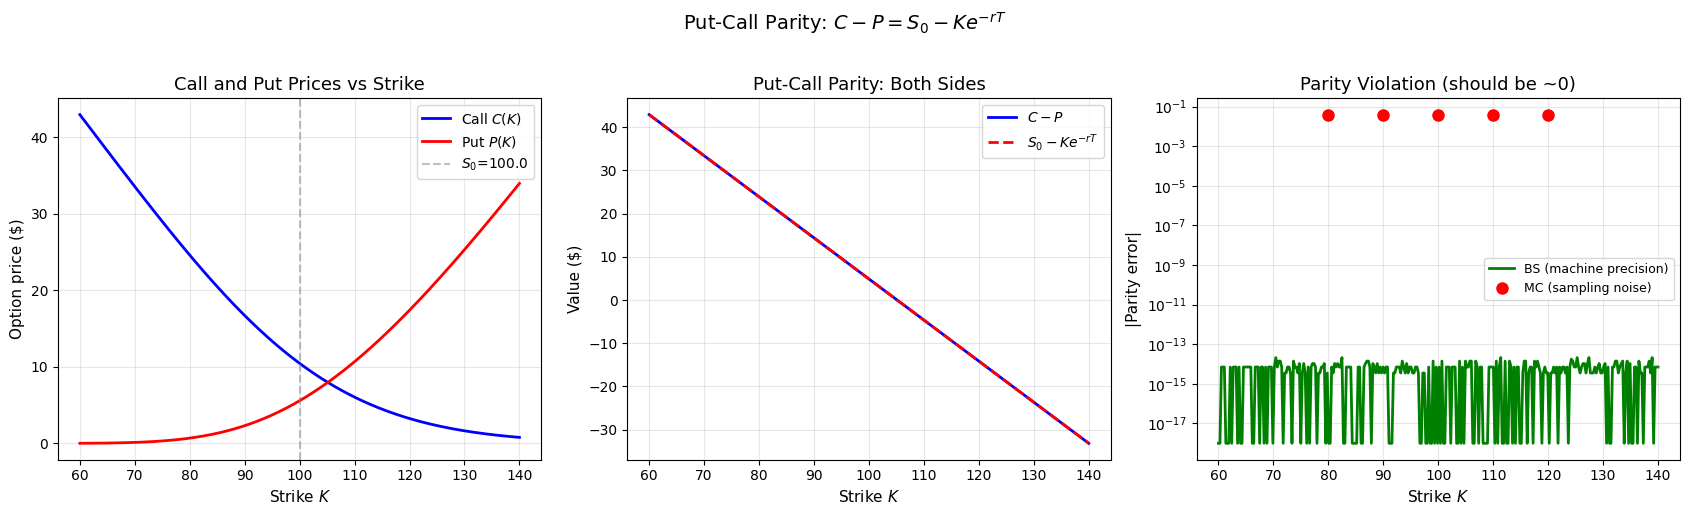

In [5]:
S0, T, r, sigma = 100.0, 1.0, 0.05, 0.20

# --- Verify across strikes ---
K_range = np.linspace(60, 140, 300)
calls_bs = bs_call(S0, K_range, T, r, sigma)
puts_bs = bs_put(S0, K_range, T, r, sigma)
parity_lhs = calls_bs - puts_bs
parity_rhs = S0 - K_range * np.exp(-r * T)

# --- Monte Carlo verification ---
np.random.seed(99)
M = 500000
Z = np.random.randn(M)
K_test = np.array([80, 90, 100, 110, 120])

mc_results = []
for K_val in K_test:
    S_T = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
    call_mc = np.exp(-r * T) * np.mean(np.maximum(S_T - K_val, 0))
    put_mc = np.exp(-r * T) * np.mean(np.maximum(K_val - S_T, 0))
    parity_diff = (call_mc - put_mc) - (S0 - K_val * np.exp(-r * T))
    mc_results.append((K_val, call_mc, put_mc, parity_diff))

print("Monte Carlo Put-Call Parity Check (M=500,000):")
print(f"{'K':>6} {'C_mc':>10} {'P_mc':>10} {'C-P':>10} {'S-Ke^-rT':>10} {'Error':>12}")
print('-' * 62)
for K_val, c, p, err in mc_results:
    forward = S0 - K_val * np.exp(-r * T)
    print(f"{K_val:>6.0f} {c:>10.4f} {p:>10.4f} {c - p:>10.4f} {forward:>10.4f} {err:>12.6f}")

# --- Visualization ---
fig, axes = plt.subplots(1, 3, figsize=(17, 5))

# Panel 1: Call and Put prices
ax = axes[0]
ax.plot(K_range, calls_bs, 'b-', linewidth=2, label='Call $C(K)$')
ax.plot(K_range, puts_bs, 'r-', linewidth=2, label='Put $P(K)$')
ax.axvline(S0, color='gray', linestyle='--', alpha=0.5, label=f'$S_0$={S0}')
ax.set_xlabel('Strike $K$', fontsize=11)
ax.set_ylabel('Option price ($)', fontsize=11)
ax.set_title('Call and Put Prices vs Strike', fontsize=13)
ax.legend(fontsize=10); ax.grid(True, alpha=0.3)

# Panel 2: Put-call parity
ax = axes[1]
ax.plot(K_range, parity_lhs, 'b-', linewidth=2, label='$C - P$')
ax.plot(K_range, parity_rhs, 'r--', linewidth=2, label='$S_0 - Ke^{-rT}$')
ax.set_xlabel('Strike $K$', fontsize=11)
ax.set_ylabel('Value ($)', fontsize=11)
ax.set_title('Put-Call Parity: Both Sides', fontsize=13)
ax.legend(fontsize=10); ax.grid(True, alpha=0.3)

# Panel 3: Parity error
ax = axes[2]
parity_error = np.abs(parity_lhs - parity_rhs)
ax.semilogy(K_range, parity_error + 1e-18, 'g-', linewidth=2)
# MC points
for K_val, c, p, err in mc_results:
    ax.semilogy(K_val, abs(err), 'ro', markersize=8)
ax.set_xlabel('Strike $K$', fontsize=11)
ax.set_ylabel('|Parity error|', fontsize=11)
ax.set_title('Parity Violation (should be ~0)', fontsize=13)
ax.legend(['BS (machine precision)', 'MC (sampling noise)'], fontsize=9)
ax.grid(True, alpha=0.3)

plt.suptitle('Put-Call Parity: $C - P = S_0 - Ke^{-rT}$', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 5. Implied Volatility and the Volatility Smile

The **implied volatility** $\sigma_{\text{imp}}(K, T)$ is the value of $\sigma$ that, when plugged into
the Black-Scholes formula, reproduces the observed market price:

$$C_{\text{market}}(K, T) = C_{\text{BS}}(S_0, K, T, r, \sigma_{\text{imp}})$$

Since BS is monotonically increasing in $\sigma$ (Vega $> 0$), a unique solution exists for
any arbitrage-free price. We solve this inversion using **Newton's method**:

$$\sigma_{n+1} = \sigma_n - \frac{C_{\text{BS}}(\sigma_n) - C_{\text{market}}}{\text{Vega}(\sigma_n)}$$

In practice, markets exhibit a **volatility smile** (or skew): implied volatility varies with
strike $K$, contradicting the constant-$\sigma$ assumption of Black-Scholes. This is evidence that
the true risk-neutral distribution has heavier tails than the lognormal.

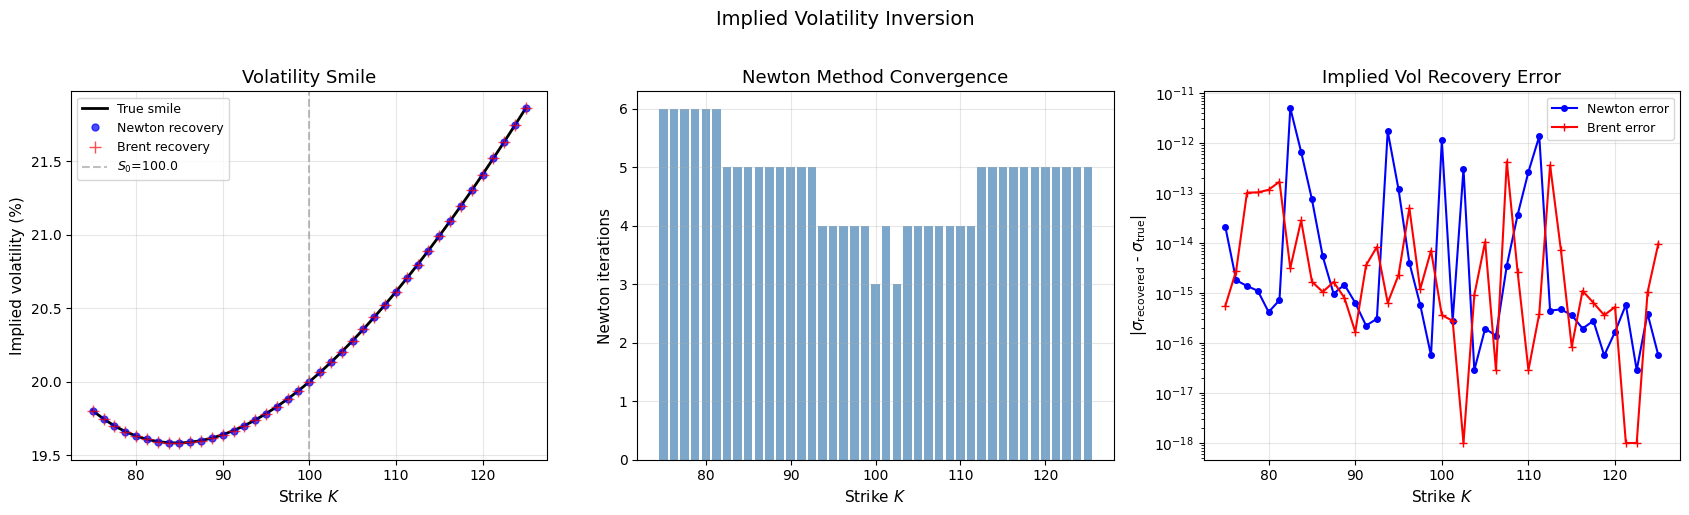

Max Newton recovery error: 5.05e-12
Max Brent recovery error:  4.30e-13
Avg Newton iterations:     4.7


In [6]:
def implied_vol_newton(market_price, S, K, T, r, sigma0=0.25, tol=1e-10, max_iter=100):
    """Compute implied volatility using Newton's method with Vega."""
    sigma = sigma0
    for i in range(max_iter):
        d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        bs_price = S * stats.norm.cdf(d1) - K * np.exp(-r * T) * stats.norm.cdf(d2)
        vega = S * stats.norm.pdf(d1) * np.sqrt(T)
        if vega < 1e-15:
            break
        diff = bs_price - market_price
        if abs(diff) < tol:
            return sigma, i + 1
        sigma = sigma - diff / vega
        sigma = max(sigma, 1e-6)  # keep sigma positive
    return sigma, max_iter


def implied_vol_brentq(market_price, S, K, T, r):
    """Compute implied volatility using Brent's method (robust fallback)."""
    def objective(sigma):
        return bs_call(S, K, T, r, sigma) - market_price
    return brentq(objective, 1e-6, 5.0)


# --- Generate synthetic market prices with a volatility smile ---
S0, T, r = 100.0, 0.5, 0.03
K_strikes = np.linspace(75, 125, 41)

# True smile: quadratic in log-moneyness
log_moneyness = np.log(K_strikes / S0)
true_smile = 0.20 + 0.15 * log_moneyness**2 + 0.05 * log_moneyness  # skewed smile

# Generate "market" prices from the smile
market_prices = np.array([bs_call(S0, K, T, r, sig) for K, sig in zip(K_strikes, true_smile)])

# --- Recover implied vols ---
recovered_vols_newton = []
newton_iters = []
recovered_vols_brent = []

for K_val, mkt_price in zip(K_strikes, market_prices):
    iv_n, n_iter = implied_vol_newton(mkt_price, S0, K_val, T, r)
    recovered_vols_newton.append(iv_n)
    newton_iters.append(n_iter)
    iv_b = implied_vol_brentq(mkt_price, S0, K_val, T, r)
    recovered_vols_brent.append(iv_b)

recovered_vols_newton = np.array(recovered_vols_newton)
recovered_vols_brent = np.array(recovered_vols_brent)

# --- Visualization ---
fig, axes = plt.subplots(1, 3, figsize=(17, 5))

# Panel 1: The volatility smile
ax = axes[0]
ax.plot(K_strikes, true_smile * 100, 'k-', linewidth=2, label='True smile')
ax.plot(K_strikes, recovered_vols_newton * 100, 'bo', markersize=5, alpha=0.7, label='Newton recovery')
ax.plot(K_strikes, recovered_vols_brent * 100, 'r+', markersize=8, alpha=0.7, label='Brent recovery')
ax.axvline(S0, color='gray', linestyle='--', alpha=0.5, label=f'$S_0$={S0}')
ax.set_xlabel('Strike $K$', fontsize=11)
ax.set_ylabel('Implied volatility (%)', fontsize=11)
ax.set_title('Volatility Smile', fontsize=13)
ax.legend(fontsize=9); ax.grid(True, alpha=0.3)

# Panel 2: Newton convergence
ax = axes[1]
ax.bar(K_strikes, newton_iters, width=1.0, color='steelblue', alpha=0.7)
ax.set_xlabel('Strike $K$', fontsize=11)
ax.set_ylabel('Newton iterations', fontsize=11)
ax.set_title('Newton Method Convergence', fontsize=13)
ax.grid(True, alpha=0.3)

# Panel 3: Recovery error
ax = axes[2]
error_newton = np.abs(recovered_vols_newton - true_smile)
error_brent = np.abs(recovered_vols_brent - true_smile)
ax.semilogy(K_strikes, error_newton + 1e-18, 'bo-', markersize=4, label='Newton error')
ax.semilogy(K_strikes, error_brent + 1e-18, 'r+-', markersize=6, label='Brent error')
ax.set_xlabel('Strike $K$', fontsize=11)
ax.set_ylabel('|$\\sigma_{\\mathrm{recovered}}$ - $\\sigma_{\\mathrm{true}}$|', fontsize=11)
ax.set_title('Implied Vol Recovery Error', fontsize=13)
ax.legend(fontsize=9); ax.grid(True, alpha=0.3)

plt.suptitle('Implied Volatility Inversion', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print(f"Max Newton recovery error: {np.max(error_newton):.2e}")
print(f"Max Brent recovery error:  {np.max(error_brent):.2e}")
print(f"Avg Newton iterations:     {np.mean(newton_iters):.1f}")

## 5b. The Smile Across Maturities: Volatility Surface

In real markets, implied volatility depends on both strike $K$ and maturity $T$, forming
a **volatility surface** $\sigma_{\text{imp}}(K, T)$. Key empirical features include:

- **Short maturities:** pronounced smile/skew (fat tails, jump risk)
- **Long maturities:** flatter smile (CLT effect, diffusion dominates)
- **Skew:** OTM puts (low $K$) often have higher implied vol than OTM calls (crash protection premium)

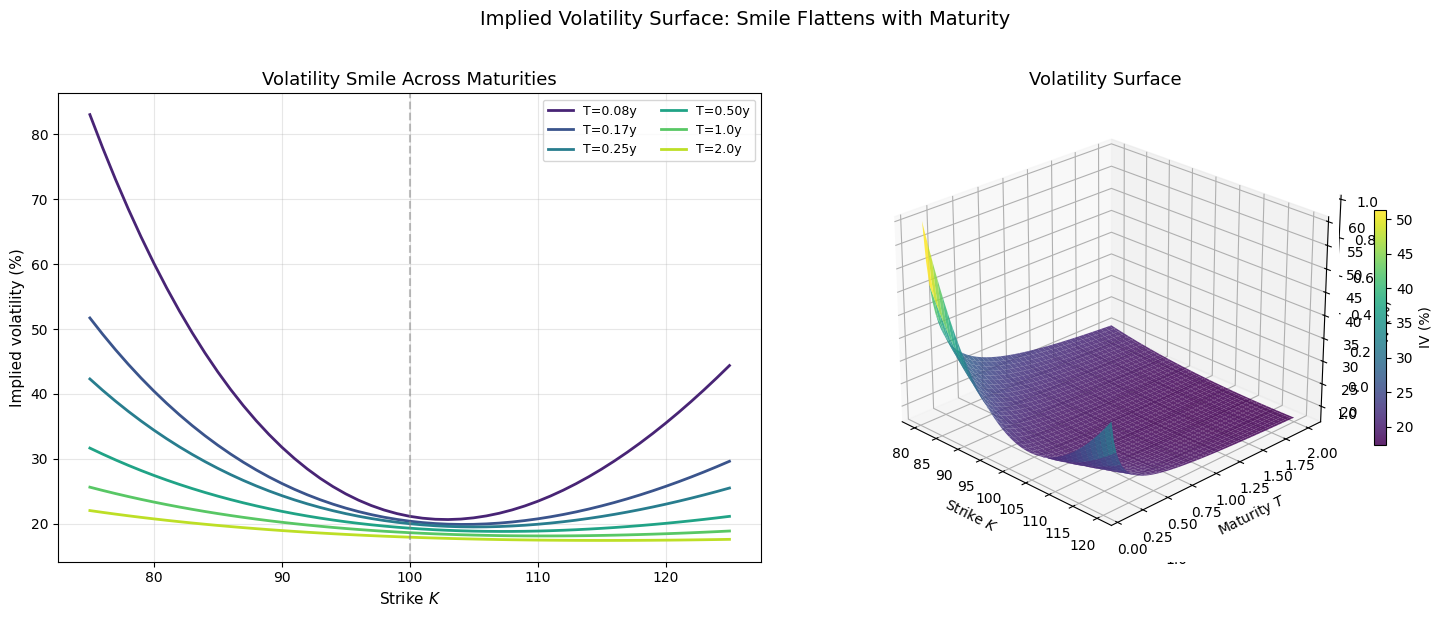

In [7]:
# --- Construct a synthetic volatility surface ---
S0, r = 100.0, 0.03
K_grid = np.linspace(75, 125, 51)
T_grid = np.array([0.08, 0.17, 0.25, 0.5, 1.0, 2.0])  # ~1mo, 2mo, 3mo, 6mo, 1yr, 2yr

def smile_model(K, T, S0):
    """Synthetic smile: ATM vol + skew + curvature, flattening with maturity."""
    m = np.log(K / S0)
    atm_vol = 0.20 - 0.01 * np.log(T / 0.25)  # term structure
    skew = -0.10 / np.sqrt(T)  # skew flattens with maturity
    curvature = 0.50 / T  # smile flattens with maturity
    return atm_vol + skew * m + curvature * m**2

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Panel 1: Smile for each maturity
ax = axes[0]
colors = plt.cm.viridis(np.linspace(0.1, 0.9, len(T_grid)))
for T_val, color in zip(T_grid, colors):
    vols = smile_model(K_grid, T_val, S0)
    label = f'T={T_val:.2f}y' if T_val < 1 else f'T={T_val:.1f}y'
    ax.plot(K_grid, vols * 100, '-', linewidth=2, color=color, label=label)
ax.axvline(S0, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Strike $K$', fontsize=11)
ax.set_ylabel('Implied volatility (%)', fontsize=11)
ax.set_title('Volatility Smile Across Maturities', fontsize=13)
ax.legend(fontsize=9, ncol=2); ax.grid(True, alpha=0.3)

# Panel 2: 3D surface
ax = fig.add_subplot(122, projection='3d')
K_fine = np.linspace(80, 120, 80)
T_fine = np.linspace(0.08, 2.0, 80)
K_mesh, T_mesh = np.meshgrid(K_fine, T_fine)
vol_surface = smile_model(K_mesh, T_mesh, S0) * 100

# Remove the flat subplot and replace with 3D
axes[1].remove()
ax = fig.add_subplot(122, projection='3d')
surf = ax.plot_surface(K_mesh, T_mesh, vol_surface, cmap='viridis', alpha=0.85,
                       edgecolor='none')
ax.set_xlabel('Strike $K$', fontsize=10)
ax.set_ylabel('Maturity $T$', fontsize=10)
ax.set_zlabel('IV (%)', fontsize=10)
ax.set_title('Volatility Surface', fontsize=13)
ax.view_init(elev=25, azim=-45)
fig.colorbar(surf, ax=ax, shrink=0.5, label='IV (%)')

plt.suptitle('Implied Volatility Surface: Smile Flattens with Maturity', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## Key Takeaways

1. **Risk-neutral pricing:** The Black-Scholes formula $C_0 = S_0 \Phi(d_1) - Ke^{-rT}\Phi(d_2)$ follows directly from computing $\mathbb{E}^{\mathbb{Q}}[e^{-rT}(S_T - K)^+]$ under the lognormal distribution with drift $r$.

2. **Monte Carlo convergence:** MC estimates converge to the BS price at rate $O(1/\sqrt{M})$ by the CLT. Confidence intervals quantify the sampling uncertainty. Common random numbers dramatically reduce variance when computing differences (e.g., Greeks).

3. **Greeks and hedging:** Delta, Gamma, Vega, and Theta can be computed analytically, by finite differences on the closed-form, or by bumping MC simulations. All three approaches agree, validating the implementation.

4. **Put-call parity:** The model-free relationship $C - P = S_0 - Ke^{-rT}$ holds exactly in the BS formula and to within MC sampling noise in simulations. It is a fundamental no-arbitrage constraint.

5. **Implied volatility and the smile:** The BS formula can be inverted (via Newton or Brent) to extract the market's implied volatility. The observed strike-dependence of implied vol (the "smile") reveals that the true risk-neutral distribution has heavier tails than the lognormal, motivating stochastic volatility and jump-diffusion models.